In [1]:
from netCDF4 import Dataset
import numpy as np
import pandas as pd
from scipy import stats
import itertools
import gsw

import matplotlib as mpl
import matplotlib.cm  as cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec

import plot_recipes as pr

In [2]:
depth_global = {}
instrument_labels = {}
instrument_colors = {}
instrument_names = {}

for y in range(2011, 2020):
    depths = []
    labels = []
    colors = []
    
    with Dataset(f'../netcdf/{y}/sbe.nc', 'r') as nc:
        depths = itertools.chain(depths, list(nc['DEPTH'][:]))
        labels = itertools.chain(labels, [u'^' for i in range(len(nc['DEPTH'][:]))])
        colors = itertools.chain(colors, ['r' for i in range(len(nc['DEPTH'][:]))])
        
        #aquadopp
        if y==2014:
            depths = itertools.chain(depths, [1700-14])
        elif y ==2013:
            print('no aquadopp in 2013')

        else:
            depths = itertools.chain(depths, [nc['DEPTH'][:].max() - 10])
        labels = itertools.chain(labels, [u's'])
        colors = itertools.chain(colors, ['y'])
        
    with Dataset(f'../netcdf/{y}/rbr.nc', 'r') as nc:
        depths = itertools.chain(depths, list(nc['DEPTH'][:]))
        labels = itertools.chain(labels, [u'o' for i in range(len(nc['DEPTH'][:]))])
        colors = itertools.chain(colors, ['k' for i in range(len(nc['DEPTH'][:]))])
        
    depth_global[y] = list(depths)
    instrument_labels[y] = list(labels)
    instrument_colors[y] = list(colors)

no aquadopp in 2013


https://stackoverflow.com/questions/26490817/matplotlib-scatter-plot-with-different-markers-and-colors

In [21]:
depth_global

{2011: [1688, 1000],
 2012: [1350, 1688, 1000],
 2013: [1350, 1688, 1000],
 2014: [1000, 1350],
 2015: [1688, 1000],
 2016: [1000, 1688],
 2017: [992, 1686],
 2018: [1000, 1689],
 2019: [1689, 1000]}

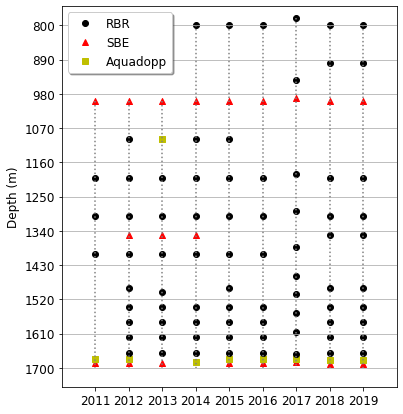

In [3]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(6,7))
for yy in range(2011,2020):
    X = np.zeros(len(depth_global[yy])) + yy
    Y = np.array(depth_global[yy])
    s = instrument_labels[yy]
    Col = instrument_colors[yy]
    
    plt.plot([yy,yy], [min(depth_global[yy]), 1700],
            linestyle=':', color='gray')
    
    for _s, col, _x, _y in zip(s, Col, X, Y):
        plt.scatter(_x, _y, marker=_s, facecolors=col, edgecolors=col)
        
plt.gca().invert_yaxis()
plt.yticks(np.linspace(800, 1700, 11))
plt.xticks(np.linspace(2011, 2019, 9))
plt.ylim(1750, 750)
plt.xlim(2010, 2020)
plt.grid(axis='y', ls='-')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], linestyle='', marker='o', c='k'),
         Line2D([0], [0], linestyle='', marker='^', c='r'),
         Line2D([0], [0], linestyle='', marker='s', c='y')]
labels = ['RBR', 'SBE', 'Aquadopp']
plt.legend(lines, labels, shadow=True)
plt.ylabel('Depth (m)')
#plt.title('Theoretical mooring depths')
plt.savefig('../figures/report_figures/theoretical_position', facecolor=(1,0,0,0))

# Real depths

In [4]:
#SBEs have pressure, therefore they are my 'anchorpoints' to set the real depth of the moorings
depth_global = {}
mean_pressure_global = {}
std_pressure_global = {} #why not?

for y in range(2011, 2020):
    with Dataset(f'../netcdf/{y}/sbe.nc', 'r') as nc:
        
        depth_global[y] = list(nc['DEPTH'][:])
        aux = {}
        aux2 = {}
        
        for i in depth_global[y]:
            try:
                aux[i] = np.array(nc[(str(i))]['PRES'][:]).mean()
                aux2[i] = np.array(nc[(str(i))]['PRES'][:]).std()
                
            except:
                print(f'{y}-{i} has no presure')
                
        mean_pressure_global[y] = aux
        std_pressure_global[y] = aux2

2012-1350 has no presure
2012-1688 has no presure
2013-1350 has no presure
2013-1688 has no presure
2018-1000 has no presure


In [7]:
#SBEs have pressure, therefore they are my 'anchorpoints' to set the real depth of the moorings
diff_global_max = {}
diff_global_min = {}
lat = 37.28 #luck strike latitude

for y in range(2011, 2020):
    with Dataset(f'../netcdf/{y}/sbe.nc', 'r') as nc:
        
        depth_global[y] = list(nc['DEPTH'][:])
        difference_max = 0
        difference_min = 1000
        
        for depth_teo in depth_global[y]:
            try:
                p_i = np.array(nc[(str(depth_teo))]['PRES'][:]).mean()
                depth_i = gsw.z_from_p(p_i, lat) # computes the measured depth from the mean pressure
                depth_teo = -depth_teo
                
                if difference_max < abs(depth_i - depth_teo):
                    difference_max = depth_i - depth_teo
                    
                if difference_min > abs(depth_i - depth_teo):
                    difference_min = depth_i - depth_teo
                    
                print(y, depth_teo, depth_i, f'-- dif = {depth_i - depth_teo}')
                
            except:
                print(f'{y}-{depth_teo} has no presure')
                
        
        print('-----------')
        diff_global_max[y] = difference_max
        diff_global_min[y] = difference_min

2011 -1688 -1707.615851867219 -- dif = -19.615851867218908
2011 -1000 -1011.4226826311285 -- dif = -11.42268263112851
-----------
2012-1350 has no presure
2012-1688 has no presure
2012 -1000 -1061.6607809377797 -- dif = -61.66078093777969
-----------
2013-1350 has no presure
2013-1688 has no presure
2013 -1000 -996.2975051174618 -- dif = 3.70249488253819
-----------
2014 -1000 -999.6848625973056 -- dif = 0.31513740269440405
2014 -1350 -1349.9507222327886 -- dif = 0.04927776721137889
-----------
2015 -1688 -1687.5962923479628 -- dif = 0.40370765203715564
2015 -1000 -989.6829439784469 -- dif = 10.317056021553071
-----------
2016 -1000 -988.6204007574324 -- dif = 11.379599242567565
2016 -1688 -1691.3022028677358 -- dif = -3.3022028677357866
-----------
2017 -992 -1007.4253445667844 -- dif = -15.42534456678436
2017 -1686 -1690.7667818233629 -- dif = -4.766781823362862
-----------
2018-1000 has no presure
2018 -1689 -1679.6362077680615 -- dif = 9.363792231938532
-----------
2019 -1689 -1683

In [12]:
1720 - 1688

32

In [8]:
#SBEs have pressure, therefore they are my 'anchorpoints' to set the real depth of the moorings
diff_global = {}

for y in range(2011, 2020):
    with Dataset(f'../netcdf/{y}/sbe.nc', 'r') as nc:
        
        depth_global[y] = list(nc['DEPTH'][:])
        difference = 0
        k = 0
        
        for depth_teo in depth_global[y]:
            try:
                p_i = np.array(nc[(str(depth_teo))]['PRES'][:]).mean()
                depth_i = gsw.z_from_p(p_i, lat) # computes the measured depth from the mean pressure
                depth_teo = -depth_teo
               
                if k > depth_teo:
                    difference = depth_i - depth_teo
                    k = depth_teo
                
                print(k, y, depth_teo, depth_i, f'-- dif = {depth_i - depth_teo}')
                
            except:
                print(f'{y}-{depth_teo} has no presure')
        
        print('-----------')
        diff_global[y] = difference

-1688 2011 -1688 -1707.615851867219 -- dif = -19.615851867218908
-1688 2011 -1000 -1011.4226826311285 -- dif = -11.42268263112851
-----------
2012-1350 has no presure
2012-1688 has no presure
-1000 2012 -1000 -1061.6607809377797 -- dif = -61.66078093777969
-----------
2013-1350 has no presure
2013-1688 has no presure
-1000 2013 -1000 -996.2975051174618 -- dif = 3.70249488253819
-----------
-1000 2014 -1000 -999.6848625973056 -- dif = 0.31513740269440405
-1350 2014 -1350 -1349.9507222327886 -- dif = 0.04927776721137889
-----------
-1688 2015 -1688 -1687.5962923479628 -- dif = 0.40370765203715564
-1688 2015 -1000 -989.6829439784469 -- dif = 10.317056021553071
-----------
-1000 2016 -1000 -988.6204007574324 -- dif = 11.379599242567565
-1688 2016 -1688 -1691.3022028677358 -- dif = -3.3022028677357866
-----------
-992 2017 -992 -1007.4253445667844 -- dif = -15.42534456678436
-1686 2017 -1686 -1690.7667818233629 -- dif = -4.766781823362862
-----------
2018-1000 has no presure
-1689 2018 -168

In [14]:
diff_global[2012] = -32
diff_global

{2011: -19.615851867218908,
 2012: -32,
 2013: 3.70249488253819,
 2014: 0.04927776721137889,
 2015: 0.40370765203715564,
 2016: -3.3022028677357866,
 2017: -4.766781823362862,
 2018: 9.363792231938532,
 2019: 5.9040092432962865}

In [15]:
import pickle

In [16]:
outfile = open('../support_data/depth_corrections','wb')
pickle.dump(diff_global,outfile)
outfile.close()

In [59]:
real_depth_global = {}
instrument_labels = {}
instrument_colors = {}
instrument_names = {}

for y in range(2011, 2020):
    depths = []
    labels = []
    colors = []
    
    with Dataset(f'../netcdf/{y}/sbe.nc', 'r') as nc:
        depths = itertools.chain(depths, list(-nc['DEPTH'][:] + diff_global[y]))
        labels = itertools.chain(labels, [u'^' for i in range(len(-nc['DEPTH'][:]))])
        colors = itertools.chain(colors, ['tab:red' for i in range(len(-nc['DEPTH'][:]))])
        
        #aquadopp
        if y==2014:
            depths = itertools.chain(depths, [-1700+14])
        elif y ==2013:
            print('no aquadopp in 2013')
        else:
            depths = itertools.chain(depths, [-nc['DEPTH'][:].max() + 10 + diff_global[y]])
            # -10m addition is an artistic license in reality is 2m.
        labels = itertools.chain(labels, [u's'])
        colors = itertools.chain(colors, ['tab:green'])
        
    with Dataset(f'../netcdf/{y}/rbr.nc', 'r') as nc:
        depths = itertools.chain(depths, list(-nc['DEPTH'][:] + diff_global[y]))
        labels = itertools.chain(labels, [u'o' for i in range(len(nc['DEPTH'][:]))])
        colors = itertools.chain(colors, ['k' for i in range(len(nc['DEPTH'][:]))])
        
    real_depth_global[y] = list(depths)
    instrument_labels[y] = list(labels)
    instrument_colors[y] = list(colors)

no aquadopp in 2013


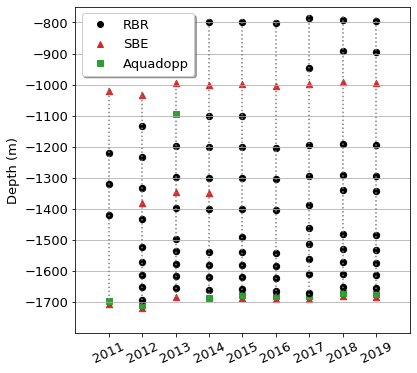

In [67]:
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(6,6))
for yy in range(2011,2020):
    X = np.zeros(len(real_depth_global[yy])) + yy
    Y = np.array(real_depth_global[yy])
    s = instrument_labels[yy]
    Col = instrument_colors[yy]
    
    plt.plot([yy,yy], [min(real_depth_global[yy]), max(real_depth_global[yy])+ 12],
            linestyle=':', color='gray')
    
    for _s, col, _x, _y in zip(s, Col, X, Y):
        plt.scatter(_x, _y, marker=_s, facecolors=col, edgecolors=col, s=40)
        
plt.gca().invert_yaxis()
plt.yticks(np.linspace(-800, -1700, 10))
plt.xticks(np.linspace(2011, 2019, 9))
plt.ylim(-1800, -750)
plt.xlim(2010, 2020)
plt.grid(axis='y', ls='-')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], linestyle='', marker='o', c='k'),
         Line2D([0], [0], linestyle='', marker='^', c='tab:red'),
         Line2D([0], [0], linestyle='', marker='s', c='tab:green')]
labels = ['RBR', 'SBE', 'Aquadopp']
plt.legend(lines, labels, shadow=True)
plt.ylabel('Depth (m)')
plt.xticks(rotation= 25)
#plt.title('Corrected mooring depths')
plt.savefig('../figures/report_figures/real_position', facecolor=(1,0,0,0))

This figure is still something approximative. The discrepancy between the differences between measured pressure and the theoretical one for two SBEs in the same mooring is not the same. One good thing could be to check the instrument error and see is the difference between the difference lies within that error. 

-----

Based on the last plot, we can see can compare the instruments that lie in at the same depth for all the years. If we see the theoretical depths plots, we see that the SBEs at 1700m and 1000m are good candidates, even though in the corrected plot we see that for 2012 the instruemnts are located around 72 m bellow the others. And for 2011 the instruments lie bellow 40m and 20m bellow the theoretical value.  

In [21]:
temp_1700 = {}
i_level = 1688
tolerance = 5

for y in range(2011,2020):
    with Dataset(f'../netcdf/{y}/sbe.nc', 'r') as nc:
        
        depth_y = list(nc['DEPTH'][:])
        level_label = None
        
        for d_i in range(i_level - tolerance, i_level + tolerance):
            if d_i in depth_y:
                level_label = str(d_i)
                
        try:
            temp_1700[y] = np.array(nc[level_label]['TEMP'][:])
        except:
            print(f'{y} has no {i_level}m ± {tolerance}m level')


2014 has no 1688m ± 5m level


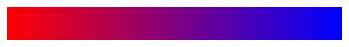

In [22]:
redblue = pr.custom_cmap(['red', 'blue'])
pr.display_cmap(redblue)

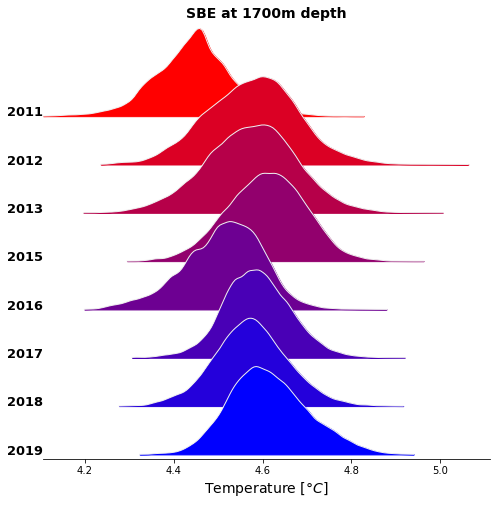

In [23]:
pr.ridge_plot(temp_1700, 
              xlabel=r'Temperature [$\degree C$]', 
              title='SBE at 1700m depth',
              cmap=redblue)

> OBS: there is no SBE at 1700 m. Probably I need to leave a gap for that year to make it explicit. 

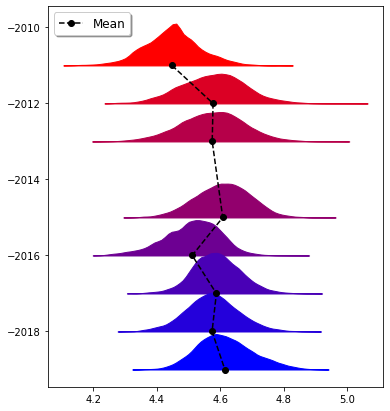

In [24]:
pr.waterfall_plot(temp_1700, 
              cmap=redblue, dist_height=0.2)

In [25]:
diff_global

{2011: -19.615851867218908,
 2012: -61.66078093777969,
 2013: 3.70249488253819,
 2014: 0.04927776721137889,
 2015: 0.40370765203715564,
 2016: -3.3022028677357866,
 2017: -4.766781823362862,
 2018: 9.363792231938532,
 2019: 5.9040092432962865}

In [26]:
temp_1000 = {}
i_level = 1000
tolerance = 10

for y in range(2011,2020):
    if y == 2018:
        # just realized that 2018  at 1000m doesn't make sense at all!
        continue
        
    with Dataset(f'../netcdf/{y}/sbe.nc', 'r') as nc:
        
        depth_y = list(nc['DEPTH'][:])
        level_label = None
        
        for d_i in range(i_level - tolerance, i_level + tolerance):
            if d_i in depth_y:
                level_label = str(d_i)
                
        try:
            temp_1000[y] = np.array(nc[level_label]['TEMP'][:])
        except:
            print(f'{y} has no {i_level}m ± {tolerance}m level')


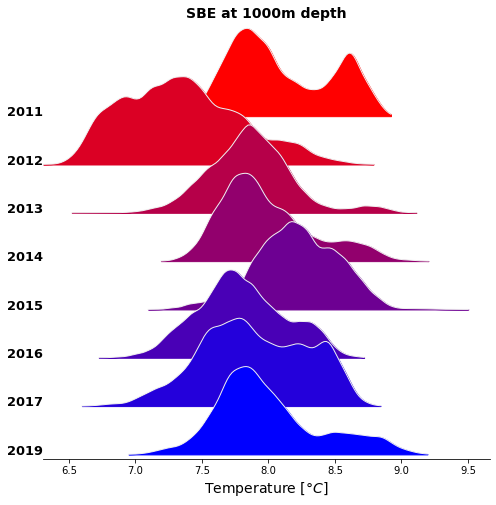

In [27]:
pr.ridge_plot(temp_1000, 
              r'Temperature [$\degree C$]',
              title='SBE at 1000m depth', 
              cmap=redblue)

> OBS: This is weird... is possible to see the that the mean temperature in 2012 is 0.5 degC bellow the rest and this could be due to the depth difference for that mooring. But in for the 1700m comparisson this perturbation is small compared to the rest. 

### RBRs interanual

Uff, is tricky. I need to select the instruments that are at similar depths from the corrected depth plot but identify the labels of the instruments from the theoretical plot. Anyway, like my homie Elvis said: "little less conversation, little more action."

![../../../Desktop/theoretical_depths.png](../../../Desktop/theoretical_depths.png) 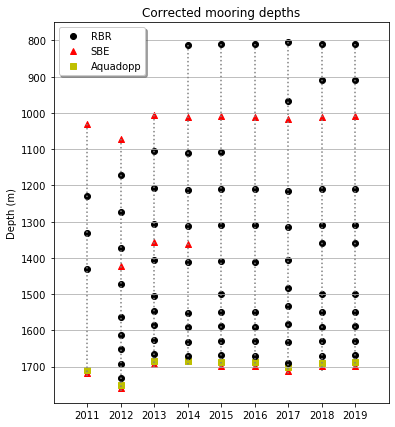


In [20]:
temp_1200 = {}
i_level = 1200
for y in range(2011,2020):
    with Dataset(f'../netcdf/{y}/rbr.nc', 'r') as nc:
        depth_y = np.array(nc['DEPTH'][:])
        
        #print(y, depth_y)
        
        if y==2017:
            idx = np.where(depth_y==1190)[0]
            print(idx)
            temp_1200[y] = np.array(nc['TEMP'][:,2])
            continue
        
        idx = np.where(depth_y==i_level)[0]
                
        #print(y, idx)
        for i in idx:
            temp_1200[y] = np.array(nc['TEMP'][:,i])
            
with Dataset(f'../netcdf/{2017}/rbr.nc', 'r') as nc:
    temp_1200[2017] = np.array(nc['TEMP'][:,2])

/Users/claudiopierard/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less
/Users/claudiopierard/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater


[2]


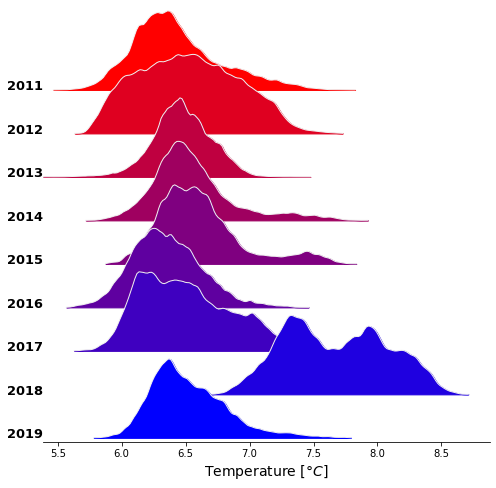

In [85]:
pr.ridge_plot(temp_1200, r'Temperature [$\degree C$]', cmap=redblue)

...